## Baseline model for TF-IDF and NB

In [2]:
# Importing Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time  
import re   

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score
)

In [4]:
# Loading the data
# I'm using 100k sample for baseline
filename = 'complaints.csv' 
try:
    df = pd.read_csv(filename, nrows=100000)
    print(f"Successfully loaded {len(df)} rows from {filename}.")
except FileNotFoundError:
    print(f"ERROR: File '{filename}' not found.")
    raise

Successfully loaded 100000 rows from complaints.csv.


In [6]:
# Pre-processing Data (Using EDA Findings)

feature_column = 'Consumer complaint narrative'
label_column = 'Product'

# Dropping rows where the narrative is missing
df.dropna(subset=[feature_column], inplace=True)
print(f"Rows remaining after dropping missing narratives: {len(df)}")


# Merging duplicate categories
print("Cleaning and merging duplicate categories...")
credit_categories = [
    'Credit reporting, credit repair services, or other personal consumer reports',
    'Credit reporting or other personal consumer reports',
    'Credit reporting'
]
clean_name = 'Credit Reporting' 
df[label_column] = df[label_column].replace(credit_categories, clean_name)
print("Category merging complete.")

Rows remaining after dropping missing narratives: 6868
Cleaning and merging duplicate categories...
Category merging complete.


In [10]:
# Splitting the data
# Cleaning "xxxx" from X
print("Removing PII redaction 'xxxx' tokens from narratives")
# This regex replaces any word made *only* of 'x' or 'X' with a space.
X = df[feature_column].replace(r'\b[xX]+\b', ' ', regex=True)
y = df[label_column]
print("Redaction cleaning complete.")

Removing PII redaction 'xxxx' tokens from narratives
Redaction cleaning complete.


In [12]:
# Splitting into training and testing 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    
    random_state=42,  
    stratify=y        # to maintain class balance in train and test data
)

print(f"Training set size: {len(X_train)}, Testing set size: {len(X_test)}")
print(f"Total categories in y_train: {len(y_train.unique())}")

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

The least populated class in y has only 1 member, meaning that in 100,000-row sample, at least one "Product" category has only one single complaint.
Hence train_test_split can't split that 1 complaint into both a training set and a testing set.

In [15]:
# Removing rare classes 
print("Finding and removing rare classes (n < 2)...")

# Get the counts for each class in 'y'
class_counts = y.value_counts()

# Finding the list of classes that have fewer than 2 samples
rare_classes = class_counts[class_counts < 2].index.tolist()


Finding and removing rare classes (n < 2)...


In [17]:
if len(rare_classes) > 0:
    print(f"Found {len(rare_classes)} rare classes with only 1 sample: {rare_classes}")
   
    keep_indices = y.isin(rare_classes) == False
    
    X_filtered = X[keep_indices]
    y_filtered = y[keep_indices]
    
    print(f"Filtered data. Old size: {len(y)}, New size: {len(y_filtered)}")
else:
    print("No rare classes found. Proceeding with original data.")
    X_filtered = X
    y_filtered = y

Found 1 rare classes with only 1 sample: ['Payday loan']
Filtered data. Old size: 6868, New size: 6867


In [19]:
# Splitting into training and testing 

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered,  
    test_size=0.2,   
    random_state=42, 
    stratify=y_filtered 
)

print(f"Training set size: {len(X_train)}, Testing set size: {len(X_test)}")
print(f"Total categories in y_train: {len(y_train.unique())}")

Training set size: 5493, Testing set size: 1374
Total categories in y_train: 16


# Creating the scikit-learn pipeline
This pipeline does two things as planned in the proposal:
1. 'tfidf': Converts text to TF-IDF features
2. 'nb_classifier': Trains the Naive Bayes model

In [24]:
nb_pipeline = Pipeline([
    (
        'tfidf',
        TfidfVectorizer(
            stop_words='english',
            max_features=5000  # Only keep the top 5000 words
        )
    ),
    (
        'nb_classifier',
        MultinomialNB()
    )
])

print("\nPipeline created:")
print(nb_pipeline)


Pipeline created:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('nb_classifier', MultinomialNB())])


In [30]:
print("\nVerifying Data Shapes")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nTotal training samples: {len(X_train)}")
print(f"Total testing samples: {len(X_test)}")


Verifying Data Shapes
X_train shape: (5493,)
y_train shape: (5493,)
X_test shape: (1374,)
y_test shape: (1374,)

Total training samples: 5493
Total testing samples: 1374


# Training the baseline Naive Bayes model

In [35]:
print("\nTraining the baseline Naive Bayes model...")
start_time = time.time()
nb_pipeline.fit(X_train, y_train)
end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")


Training the baseline Naive Bayes model...
Training finished in 0.63 seconds.


# Evaluating the baseline model

In [38]:
print("\nEvaluating the baseline model...")
y_pred = nb_pipeline.predict(X_test)

# Primary Metric: Macro-Averaged F1-Score
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"\n--- BASELINE MODEL RESULTS ---")
print(f"Macro-Averaged F1-Score: {macro_f1:.4f}")

# Supporting Metrics: Per-Class Report
print("\nFull Classification Report:")
sorted_labels = nb_pipeline.classes_
print(classification_report(y_test, y_pred, labels=sorted_labels))



Evaluating the baseline model...

--- BASELINE MODEL RESULTS ---
Macro-Averaged F1-Score: 0.1934

Full Classification Report:
                                                         precision    recall  f1-score   support

                                Bank account or service       0.00      0.00      0.00         3
                            Checking or savings account       0.53      0.61      0.57        71
                                          Consumer Loan       0.00      0.00      0.00         3
                                       Credit Reporting       0.80      0.99      0.89       920
                                            Credit card       0.38      0.09      0.14        57
                            Credit card or prepaid card       0.00      0.00      0.00        29
                                        Debt collection       0.51      0.37      0.43       156
                              Debt or credit management       0.00      0.00      0.00         4

C:\Users\vaiju\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vaiju\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vaiju\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Confusion matrix


Generating confusion matrix plot...
Saved 'baseline_confusion_matrix.png'


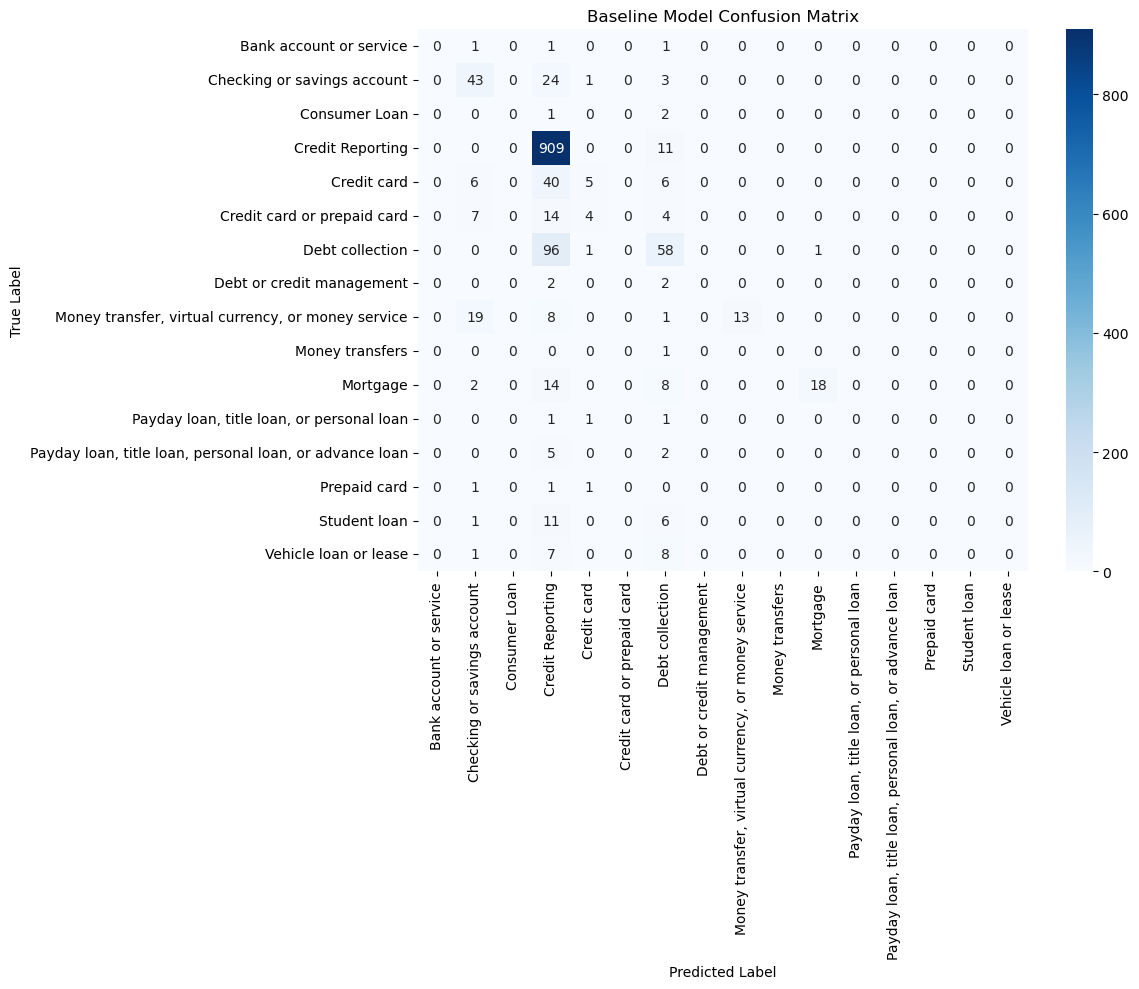

In [47]:
print("\nGenerating confusion matrix plot...")

cm = confusion_matrix(y_test, y_pred, labels=sorted_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,  
    fmt='d',     # Format as integers
    cmap='Blues',
    xticklabels=sorted_labels,
    yticklabels=sorted_labels
)
plt.title('Baseline Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('baseline_confusion_matrix.png')
print("Saved 'baseline_confusion_matrix.png'")